In [1]:
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import umap
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
import cv2


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("../1_Fetal_gradcams/manual_annot_CRL_Sagittal.txt", "r") as file:
    # Read the contents of the file
    file_contents = file.read()
lines = file_contents.split('\n')
index = [int(i.split(' ')[0]) for i in lines]
labels = [' '.join(i.split(' ')[1:]) for i in lines]
manual_labels_df = pd.DataFrame()
manual_labels_df['Image ID'] = index
manual_labels_df['label'] = labels

manual_labels_df['label'] = manual_labels_df['label'].apply(lambda x: x.strip())

manual_labels_df = manual_labels_df[manual_labels_df['label'] != 'remove']

num_labels = {'head': 0, 'neck': 1, 'body': 2}

manual_labels_df['encoded_label'] = manual_labels_df['label'].map(num_labels)

y = np.array(manual_labels_df['encoded_label'])

In [3]:
imgs = np.load('../1_Fetal_gradcams/cropped_imgs_fetal_regions.npy')

In [12]:
y_series = pd.Series(y)
y_series.value_counts()

2    77
1    54
0    49
Name: count, dtype: int64

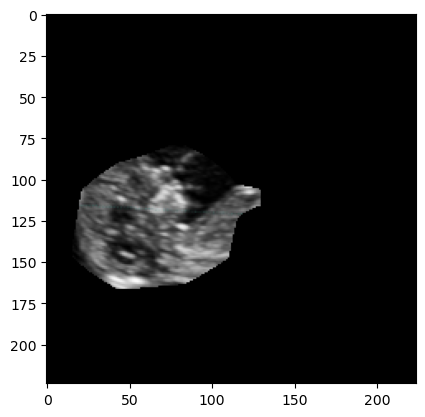

In [15]:
# Choosing the appropriate metric to compare two images
## Case 1: Similar looking head images 
i1 = imgs[2]
plt.imshow(i1)

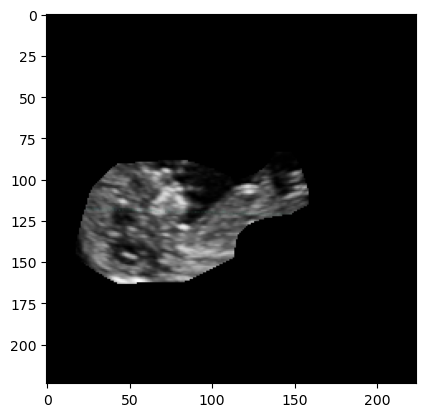

In [16]:
i2 = imgs[3]
plt.imshow(i2)

In [17]:
# SSIM similarity measure 
def calc_ssim(img1, img2):
  img1 = (img1*255).astype('uint8')
  img2 = (img2*25).astype('uint8')
  img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
  return ssim(img1_gray, img2_gray, data_range=img2_gray.max() - img2_gray.min())

In [18]:
calc_ssim(i1, i2)
## Not so bad, but now if the head is on a different location in the image

0.8040870050295601

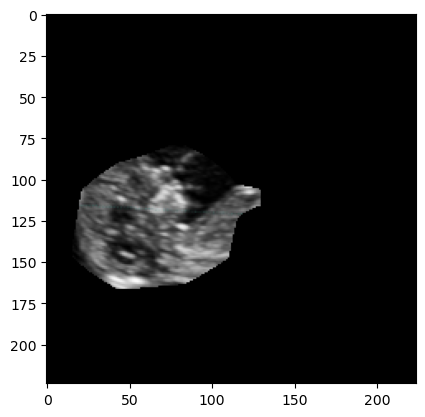

In [25]:
i1 = imgs[2]
plt.imshow(i1)

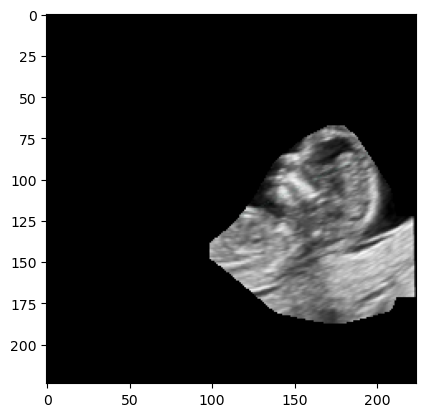

In [26]:
i2 = imgs[17]
plt.imshow(i2)

In [29]:
calc_ssim(i1, i2)

0.6097420567956945

In [22]:
# Constructing a matrix of all head images 
head_images = imgs[y == 0]
head_images.shape

(49, 224, 224, 3)

In [23]:
# Creating a 49x49 matrix each containing the pair-wise ssim metric
ssim_head_matrix = np.zeros((49, 49))
for ind1 in range(head_images.shape[0]):
    for ind2 in range(head_images.shape[0]):
        ssim_head_matrix[ind1][ind2] = calc_ssim(head_images[ind1], head_images[ind2])

In [24]:
ssim_head_matrix

array([[0.83201241, 0.80408701, 0.65729475, ..., 0.65972909, 0.66897226,
        0.62012478],
       [0.80377353, 0.81859326, 0.6648652 , ..., 0.66645637, 0.6721449 ,
        0.63352451],
       [0.66412974, 0.67361369, 0.82916156, ..., 0.8097066 , 0.80676651,
        0.76392914],
       ...,
       [0.66381086, 0.67426916, 0.80905354, ..., 0.82515896, 0.79720837,
        0.75471324],
       [0.66960466, 0.67466287, 0.80607088, ..., 0.79475482, 0.840625  ,
        0.78785802],
       [0.61447699, 0.62593218, 0.75766923, ..., 0.74750015, 0.77931802,
        0.78471831]])

In [30]:
# Analysing the min value 
ssim_head_matrix.min()

0.4626856696405268

In [31]:
# max should be there on the diagonal 
ssim_head_matrix.max()

0.9008915285208025

In [32]:
# Constructing the whole ssim matrix 
ssim_matrix = np.zeros((imgs.shape[0], imgs.shape[0]))
for ind1 in range(imgs.shape[0]):
    for ind2 in range(imgs.shape[0]):
        ssim_matrix[ind1][ind2] = calc_ssim(imgs[ind1], imgs[ind2])

In [33]:
# Analysing the min value 
ssim_matrix.min()

0.41832880627621405

In [34]:
# max should be there on the diagonal 
ssim_matrix.max()

0.903131310587968

In [36]:
# Cross analysing poor similarity score head image with other images of different classes
## ideal behaviour => similarity of that image should be < when compared for neck and body images

# Finding the minimum head SSIM image pair 
min_row, min_col = np.unravel_index(np.argmin(ssim_head_matrix), ssim_head_matrix.shape)

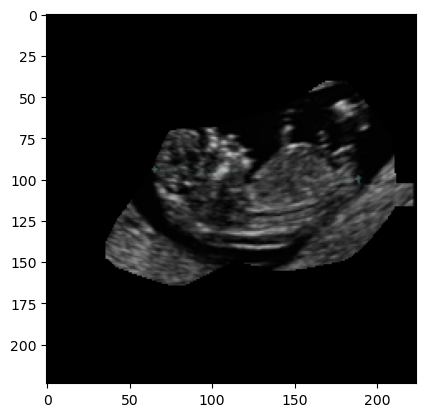

In [38]:
min_head_row_img = imgs[min_row]
plt.imshow(min_head_row_img)

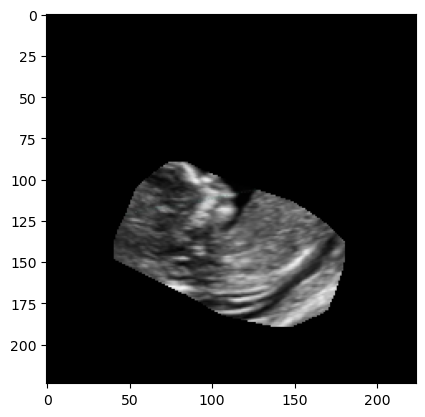

In [39]:
min_head_col_img = imgs[min_col]
plt.imshow(min_head_col_img)